Influenced by:

https://arxiv.org/abs/2011.13456

https://github.com/yang-song/score_sde

In [1]:
%%capture
!pip install torchcfm

In [2]:
%%capture
%load_ext autoreload
%autoreload 2

import os
import math
import functools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchsde
from torchdyn.core import NeuralODE

from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

from torchcfm.models.unet import UNetModel

from google.colab import drive
drive.mount('/content/drive')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%%capture

batch_size = 128 #@param {'type':'number'}

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_dataset = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transformations
)

train_data_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [5]:
#@title SDE Definition

def get_std(t, s):
  t = torch.tensor(t, device=device)
  return torch.sqrt((s**(2 * t) - 1.) / 2. / np.log(s))

def get_diff_coef(t, s):
  return torch.tensor(s**t, device=device)

sigma =  20 #@param {'type':'number'}
get_std_fn = functools.partial(get_std, s=sigma)
get_diff_coef_fn = functools.partial(get_diff_coef, s=sigma)

In [6]:
num_res_blocks = 3 #@param {'type':'number'}
num_channels = 64 #@param {'type':'number'}
lr = 0.0001 #@param {'type':'number'}

model = UNetModel(dim=(1, 28, 28), num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
#@title Training

final_checkpoint_path = '/content/drive/My Drive/Dissertation/models/scoremodel_50epochs_3res_64chan_20sigma.pth'

num_epochs = 1 #@param {'type':'number'}
save = False #@param {'type':'boolean'}
eps = 1e-5 #@param

for epoch in range(num_epochs):
    model.train()
    for i, (data, _) in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):
        clean = data.to(device)

        b_size = clean.shape[0]

        random_t = torch.rand(b_size, device=device) * (1. - eps) + eps

        z = torch.randn_like(clean)

        std = get_std_fn(random_t)

        x_noised = clean + z * std[:, None, None, None]

        score = model(random_t, x_noised)

        loss = torch.mean(torch.sum((score + z/std[:, None, None, None])**2, dim=(1,2,3)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

if save:
  torch.save(model.state_dict(), final_checkpoint_path)
  print(f'Saved final model checkpoint: {final_checkpoint_path}')

  0%|          | 0/468 [00:00<?, ?it/s]<ipython-input-5-8ebbd8557417>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
 66%|██████▋   | 311/468 [03:45<01:54,  1.38it/s]

In [ ]:
%%capture
#@title Load Model
final_checkpoint_path = '/content/drive/My Drive/Dissertation/models/scoremodel_50epochs_3res_64chan_25sigma.pth'
model.load_state_dict(torch.load(final_checkpoint_path))
model.eval()

In [ ]:
#@title Euler-Maruyama Sampler

num_steps = 500  # @param {'type':'integer'}

def em_sampler(model, num_samples, num_steps=num_steps, eps=1e-3):

    current_samples = torch.randn(num_samples, 1, 28, 28, device=device) * get_std_fn(torch.ones(num_samples, device=device))[:, None, None, None]

    time_grid = torch.linspace(1., eps, num_steps, device=device)

    delta = time_grid[0] - time_grid[1]

    with torch.no_grad():
        for current_time in tqdm(time_grid):
            current_time_batch = torch.ones(num_samples, device=device) * current_time
            diff_coef = get_diff_coef_fn(current_time_batch)

            mean_samples = current_samples + (diff_coef**2)[:, None, None, None] * model(current_time_batch, current_samples) * delta

            current_samples = mean_samples + torch.sqrt(delta) * diff_coef[:, None, None, None] * torch.randn_like(current_samples)

    return mean_samples


In [ ]:
#@title Predictor-Corrector Sampler

num_steps = 500  # @param {'type':'integer'}

def pc_sampler(model_fn, num_samples, signal_to_noise_ratio=0.16, num_steps=num_steps, epsilon=1e-3):
    initial_samples = torch.randn(num_samples, 1, 28, 28, device=device) \
      * get_std_fn(torch.ones(num_samples, device=device))[:, None, None, None]

    time_grid = torch.linspace(1., epsilon, num_steps, device=device)

    delta_time = time_grid[0] - time_grid[1]

    current_samples = initial_samples

    with torch.no_grad():
        for current_time in tqdm(time_grid):
            current_time_batch = torch.ones(num_samples, device=device) * current_time

            # Corrector Step
            gradient = model_fn(current_time_batch, current_samples)
            gradient_norm = torch.norm(gradient.reshape(gradient.shape[0], -1), dim=-1).mean()
            noise_magnitude = np.sqrt(np.prod(current_samples.shape[1:]))
            langevin_step_size = 2 * (signal_to_noise_ratio * noise_magnitude / gradient_norm)**2
            current_samples = current_samples + langevin_step_size * gradient \
              + torch.sqrt(2 * langevin_step_size) * torch.randn_like(current_samples)

            # Predictor Step
            diff_coef = get_diff_coef_fn(current_time_batch)
            mean_samples = current_samples + (diff_coef**2)[:, None, None, None] \
                * model_fn(current_time_batch, current_samples) * delta_time
            current_samples = mean_samples + torch.sqrt(diff_coef**2 * delta_time)[:, None, None, None] \
                * torch.randn_like(current_samples)

        return mean_samples


<ipython-input-5-869c5d3c48e2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-5-869c5d3c48e2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s**t, device=device)
100%|██████████| 500/500 [00:15<00:00, 32.45it/s]


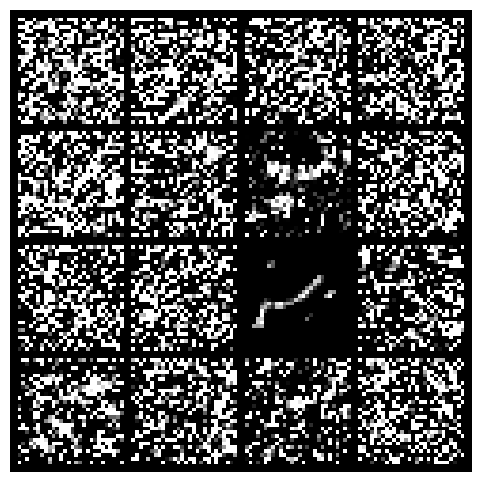

In [ ]:
#@title Sampling

sample_batch_size = 16 #@param {'type':'integer'}

# sampler = pc_sampler
sampler = em_sampler

samples = sampler(model, num_samples = sample_batch_size)

samples = samples.clip(0.0, 1.0)

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
#@title Sampling for FID

num_images = 10000 #@param {'type':'integer'}
batch_size = 100  #@param {'type':'integer'}
start_index = 0 #@param {'type':'integer'}
save_dir = "/content/drive/My Drive/Dissertation/images/score2"

os.makedirs(save_dir, exist_ok=True)

to_pil = ToPILImage()

with torch.no_grad():
    for start_idx in range(start_index, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        current_batch_size = end_idx - start_idx

        samples = sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, num_samples = sample_batch_size).clip(0, 1)

        for i, sample in enumerate(samples):
            img = to_pil(sample)
            img.save(os.path.join(save_dir, f"sample_{start_idx + i + 1}.png"))

<ipython-input-16-9192a7c9ea81>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-16-9192a7c9ea81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:14<00:00, 34.33it/s]


Generated samples saved to /content/drive/My Drive/Dissertation/images/score2
